In [1]:
import hist
import boost_histogram as bh
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from utilities import boostHistHelpers as hh
from wremnants import histselections as sel
from wremnants import datasets2016
from wremnants import plot_tools
import wremnants
import h5py
import uproot
import narf
hep.style.use(hep.style.ROOT)

sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Welcome to JupyROOT 6.28/02


In [ ]:
with h5py.File("../mw_with_mu_eta_pt_scetlib_dyturboCorr_maxFiles1.hdf5", "r") as f:
    result = narf.ioutils.pickle_load_h5py(f["results"])
    #print(result['WminustaunuPostVFP']['event_count'])
    print(result['ZmumuPostVFP']['output'].keys())

dict_keys(['mTStudyForFakes', 'mtIsoJetCharge', 'MET', 'transverseMass', 'nominal_qcdJetPt30', 'nominal', 'nominal_weight', 'nominal_recoilUnc_source_para', 'nominal_recoilUnc_source_perp', 'nominal_recoilUnc_target_para', 'nominal_recoilUnc_target_para_bkg', 'nominal_recoilUnc_target_perp', 'nominal_recoilUnc_target_perp_bkg', 'nominal_uncorr', 'weight_uncorr', 'nominal_scetlib_dyturboCorr', 'nominal_scetlib_dyturboOmega', 'nominal_gen', 'nominal_gen_smeared', 'nominal_effStatTnP_sf_reco', 'nominal_effStatTnP_sf_tracking', 'nominal_effStatTnP_sf_idip', 'nominal_effStatTnP_sf_trigger', 'nominal_effStatTnP_sf_iso', 'nominal_effSystTnP', 'nominal_muonL1PrefireStat', 'nominal_muonL1PrefireSyst', 'nominal_ecalL1Prefire', 'nominal_luminosity', 'nominal_pdfMSHT20', 'nominal_pdfMSHT20alphaS002', 'nominal_qcdScale', 'nominal_qcdScaleByHelicity', 'nominal_massWeight', 'nominal_muonScaleSyst', 'nominal_muonScaleSyst_gen_smear', 'nominal_muonScaleSystPerSeDown', 'nominal_muonScaleSystPerSeUp', 'm

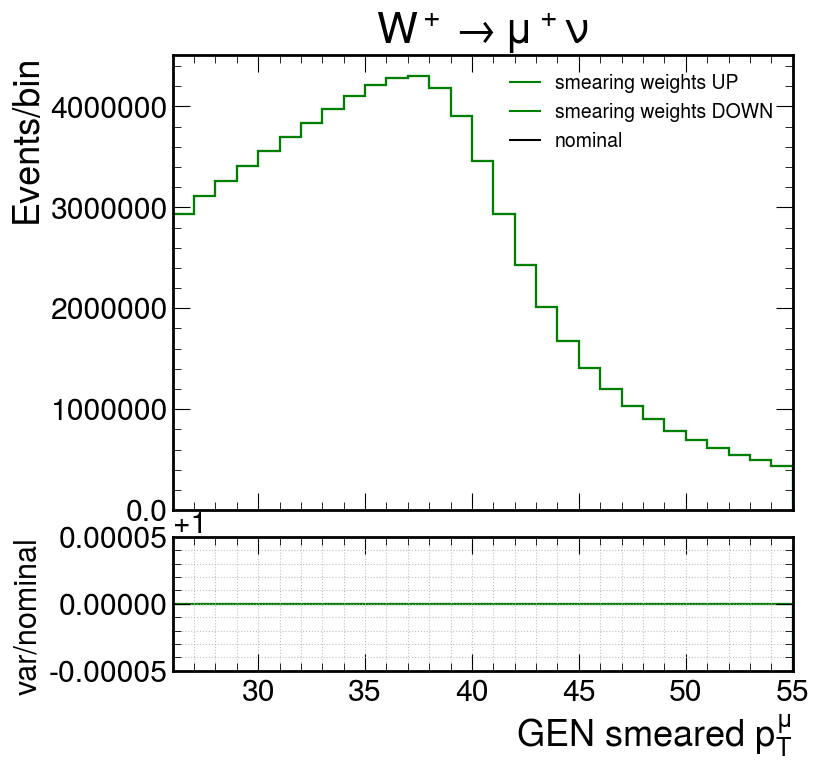

In [13]:
f = h5py.File("../mw_with_mu_eta_pt_scetlib_dyturboCorr_smearing.hdf5", "r")
results = narf.ioutils.pickle_load_h5py(f["results"])

proc = 'WplusmunuPostVFP'
proc_name_latex = {
    'WplusmunuPostVFP': r'$W^+ \rightarrow \mu^+ \nu$',
    'WminusmunuPostVFP': r'$W^- \rightarrow \mu^- \nu$',
    'ZmumuPostVFP': r'$Z \rightarrow \mu^+ \mu^-$'
}
print(results[proc]['output'].keys())

nuisances = [
    'muonScaleSyst_responseWeights',
#    'Z_non_closure_parametrized',
    'Z_non_closure_parametrized_A',
    'Z_non_closure_parametrized_M',
#    'Z_non_closure_binned'
]
hists = {}
hists['nominal'] = results[proc]['output']['nominal'].get()
hists['nominal_gensmear'] = results[proc]['output']['nominal_gen_smeared'].get()
for nuisance in nuisances:
    hists[nuisance + '_gensmear'] = results[proc]['output'][nuisance + '_gensmear'].get()
    hists['nominal_' + nuisance] = results[proc]['output']['nominal_' + nuisance].get()

action = lambda x: x.project('pt')

fig = plot_tools.makePlotWithRatioToRef(
    [
        action(hists['nominal_gensmear']),
        action(hists['muonScaleSyst_responseWeights_gensmear'][...,141,0]),
        action(hists['muonScaleSyst_responseWeights_gensmear'][...,141,1])
    ],
    labels = [
        'nominal', 
        'smearing weights DOWN',
        'smearing weights UP'
    ],
    colors = ['black', 'green', 'green'],
    rrange = [0.99995, 1.00005],
    nlegcols = 1,
    rlabel = 'var/nominal',
    xlabel = r'GEN smeared $p_T^{\mu}$',
    plot_title = proc_name_latex[proc],
    grid = True
)
#hists['nominal_Z_non_closure_parametrized'].values()

In [ ]:
hep.hist2dplot(cov)

In [14]:
import uproot
import hist
import numpy as np
from wremnants import muon_validation

def get_covmat(filepath, n_scale_params, n_tot_params, n_eta_bins):
    f = uproot.open(filepath)
    cov = f['covariance_matrix'].to_hist()
    cov_scale_params = muon_validation.get_jpsi_scale_param_cov_mat(
        cov, n_scale_params, n_tot_params, n_eta_bins
    )
    return cov_scale_params

def make_hist_covmat_diag(cov_scale_params):
    w,v = np.linalg.eigh(cov_scale_params)
    var_mat = np.sqrt(w) * v
    axis_eta = hist.axis.Regular(n_eta_bins, -2.4, 2.4, name = 'eta')
    axis_scale_params = hist.axis.Regular(n_scale_params, 0, 1, name = 'scale_params')
    axis_scale_params_unc = hist.axis.Regular(
        n_eta_bins * n_scale_params, 0, n_eta_bins * n_scale_params,
        underflow = False, overflow = False,  name = 'unc'
    )
    hist_scale_params_unc = hist.Hist(axis_eta, axis_scale_params, axis_scale_params_unc)
    for i in range(n_eta_bins):
        lb, ub = i * n_scale_params, (i + 1) * n_scale_params
        hist_scale_params_unc.view()[i,...] = var_mat[lb:ub][:]
    return hist_scale_params_unc

def get_variance_on_AeM(filepath, n_scale_params, n_tot_params, n_eta_bins):
    covmat = get_covmat(filepath, n_scale_params, n_tot_params, n_eta_bins)
    A_var = np.empty(n_eta_bins)
    e_var = np.empty(n_eta_bins)
    M_var = np.empty(n_eta_bins)
    for i in range(n_eta_bins):
        A_var[i] = (covmat.diagonal()[n_scale_params*i])
        e_var[i] = (covmat.diagonal()[n_scale_params*i+1])
        M_var[i] = (covmat.diagonal()[n_scale_params*i+2])
    return A_var, e_var, M_var

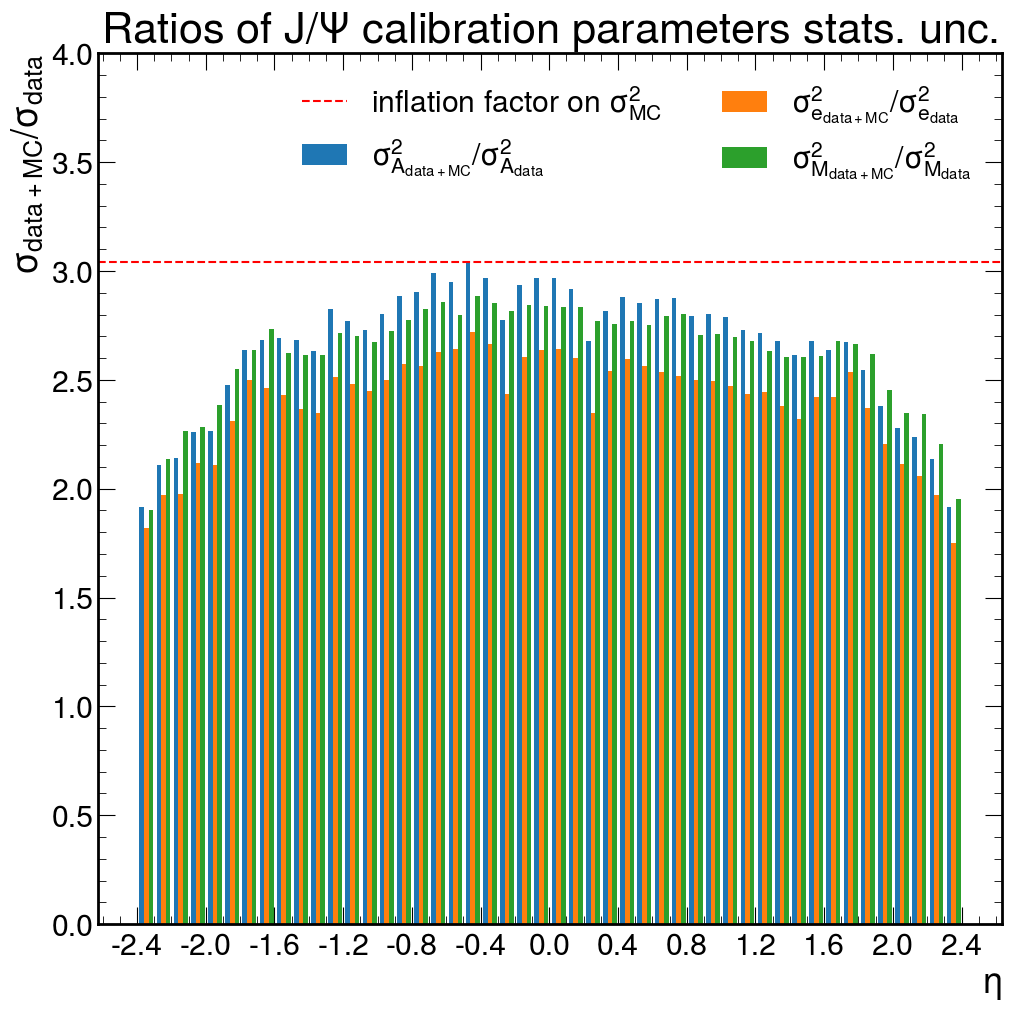

In [64]:
n_scale_params = 3
n_tot_params = 4
n_eta_bins = 48
filepath_old = '../wremnants/data/calibration/calibrationJDATA_rewtgr_3dmap_LBL_v721.root'
filepath_new = '../wremnants/data/calibration/calibrationJDATA_rewtgr_3dmap_LBL_MCstat.root'
A_var_old, e_var_old, M_var_old = get_variance_on_AeM(filepath_old, n_scale_params, n_tot_params, n_eta_bins)
A_var_new, e_var_new, M_var_new = get_variance_on_AeM(filepath_new, n_scale_params, n_tot_params, n_eta_bins)
ratio_A_var = A_var_new / A_var_old
ratio_e_var = e_var_new / e_var_old
ratio_M_var = M_var_new / M_var_old

from wremnants import plot_tools
eta = np.arange(-2.4, 2.4, 0.1)
ratio_vars = {
    r'$\sigma^2_{A_{{data+MC}}}/\sigma^2_{A_{{data}}}$': ratio_A_var,
    r'$\sigma^2_{e_{{data+MC}}}/\sigma^2_{e_{{data}}}$': ratio_e_var,
    r'$\sigma^2_{M_{{data+MC}}}/\sigma^2_{M_{{data}}}$': ratio_M_var
}
width = 0.027  # the width of the bars
multiplier = 1

fig, ax = plt.subplots(layout='constrained')

for group, var in ratio_vars.items():
    offset = width * multiplier
    rects = ax.bar(eta + offset, var, width, label=group)
    #ax.bar_label(rects, padding=3)
    multiplier += 1
ax.axhline(y=3.04, color='r', linestyle='--', label=r'inflation factor on $\sigma^2_{MC}$')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$\sigma_{data+MC}/\sigma_{data}$')
ax.set_xlabel(r'$\eta$')
ax.set_title(r'Ratios of $J/\Psi$ calibration parameters stats. unc.')
ticks = np.arange(-2.4, 2.8, 0.4)
ax.set_xticks(ticks)
ax.legend(loc='upper right', ncols = 2)
ax.set_ylim(0, 4)

plot_tools.save_pdf_and_png(
    '/eos/user/t/tyjyang/www/plots/wmass/muon-calibration/jpsi_stats_unc',
    'jpsi_stats_unc_boostrapping_vs_inflation'
)
plt.show()

In [19]:
f = uproot.open(filepath_new)
f['covariance_matrix'].values()

array([[ 1.40495600e-07,  9.31065973e-07,  1.59168866e-11, ...,
        -3.52460068e-15, -1.89146873e-15,  3.11280492e-18],
       [ 9.31065973e-07,  6.93743347e-06,  3.23525333e-10, ...,
        -2.81941932e-14, -1.49490785e-14,  2.46775250e-17],
       [ 1.59168866e-11,  3.23525333e-10,  2.16355561e-10, ...,
         8.88000151e-15,  4.61446835e-15, -7.56582504e-18],
       ...,
       [-3.52460068e-15, -2.81941932e-14,  8.88000151e-15, ...,
         6.90144899e-06, -2.74290293e-10,  8.72852644e-11],
       [-1.89146873e-15, -1.49490785e-14,  4.61446835e-15, ...,
        -2.74290293e-10,  2.14643356e-10, -1.05847410e-12],
       [ 3.11280492e-18,  2.46775250e-17, -7.56582504e-18, ...,
         8.72852644e-11, -1.05847410e-12,  8.10476009e-11]])